# Lab 3 Report:
## MNIST Classification with FCN

### Name:

In [337]:
# Import necessary packages

%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np

In [338]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [339]:
Image('lab3_exercise.PNG', width = 1000)

FileNotFoundError: No such file or directory: 'lab3_exercise.PNG'

FileNotFoundError: No such file or directory: 'lab3_exercise.PNG'

<IPython.core.display.Image object>

### Prepare Data

In [340]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy')
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


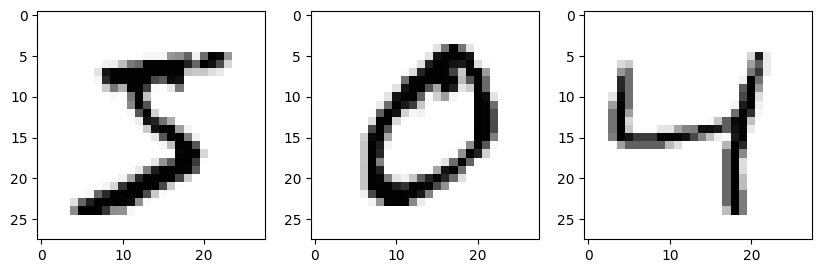

In [341]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [342]:
# Reshape features via flattening the images
# This refers to reshape each sample from a 2d array to a 1d array.
# hint: np.reshape() function could be useful here

mnist_train_features = np.reshape(mnist_train_features, (mnist_train_features.shape[0], -1))
mnist_test_features = np.reshape(mnist_test_features, (mnist_test_features.shape[0], -1))

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [343]:
# Scale the dataset according to standard scaling
# Feel free to perform additional data processing here (e.g. standard scaling)

train_mean = np.mean(mnist_train_features, axis=0)
train_std  = np.std(mnist_train_features, axis=0)
train_std[train_std == 0] = 1.0

mnist_train_features = (mnist_train_features - train_mean) / train_std
mnist_test_features  = (mnist_test_features  - train_mean) / train_std

In [344]:
# Split training dataset into Train (90%), Validation (10%)

split = int(0.9 * len(mnist_train_features))

mnist_validation_features = mnist_train_features[split:]
mnist_validation_targets  = mnist_train_targets[split:]

mnist_train_features = mnist_train_features[:split]
mnist_train_targets  = mnist_train_targets[:split]


### Define Model

In [345]:
class mnistClassification(torch.nn.Module):

    def __init__(self, input_dim, output_dim, hidden1_dim): # Feel free to add hidden_dim as parameters here

        super(mnistClassification, self).__init__()

        self.layer1 = torch.nn.Linear(input_dim, hidden1_dim)
        self.layer2 = torch.nn.Linear(hidden1_dim, output_dim)

    def forward(self, x):

        out1 = torch.nn.functional.relu(self.layer1(x))
        out = self.layer2(out1)
        return out

### Define Hyperparameters

In [346]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(input_dim=784, output_dim=10, hidden1_dim=256)

# Define the learning rate and epoch
learning_rate = 0.001
epochs = 100
#batchsize = # YOUR CODE HERE (If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
#if torch.cuda.is_available():
    #model.cuda()

#model

### Identify Tracked Values

In [347]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = np.zeros((epochs,))
validation_accuracy_list = np.zeros((epochs,))

### Train Model

In [348]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(mnist_train_features).float()
train_targets = torch.from_numpy(mnist_train_targets).long()

validation_inputs = torch.from_numpy(mnist_validation_features).float()
validation_targets = torch.from_numpy(mnist_validation_targets).long()

testing_inputs = torch.from_numpy(mnist_test_features).float()
testing_targets = torch.from_numpy(mnist_test_targets).long()

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):

    optimizer.zero_grad()

    train_outputs = model(train_inputs)

    loss = loss_func(train_outputs, train_targets)

    train_loss_list[epoch] = loss.item()

    loss.backward()

    optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():
      validation_outputs = model(validation_inputs)
      correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).float()
      validation_accuracy_list[epoch] = correct.mean().item()

100%|██████████| 100/100 [00:01<00:00, 53.97it/s]


### Visualize and Evaluate Model

In [349]:
# Import seaborn for prettier plots

import seaborn as sns


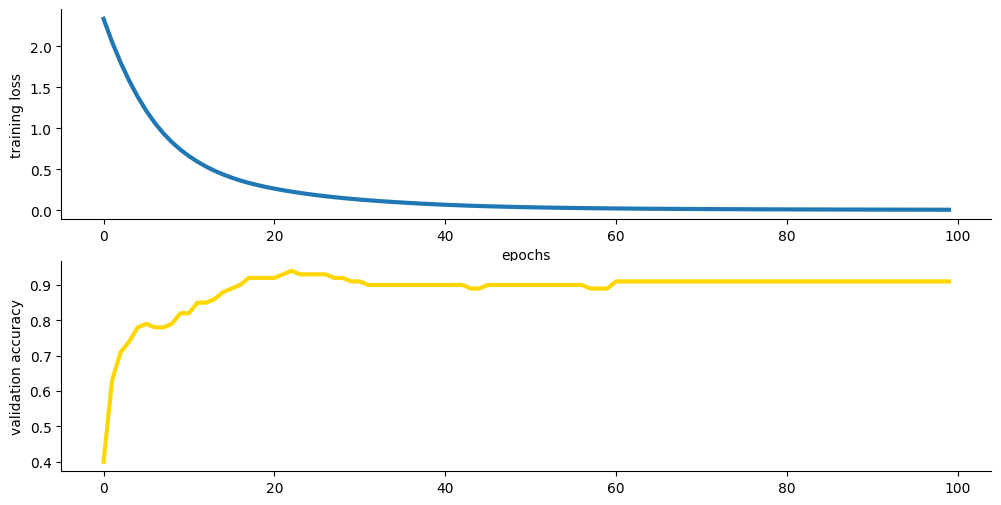

In [350]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [351]:
# Compute the testing accuracy

with torch.no_grad():

    y_pred_test = model(testing_inputs)
    predicted_classes = torch.argmax(y_pred_test, dim=1)

    correct = (predicted_classes == testing_targets).float()
    print(f"Testing Accuracy: {(correct.mean().numpy()*100)}%")

    incorrect_mask = (predicted_classes != testing_targets)
    incorrect_indices = torch.where(incorrect_mask)[0]


Testing Accuracy: 93.0%


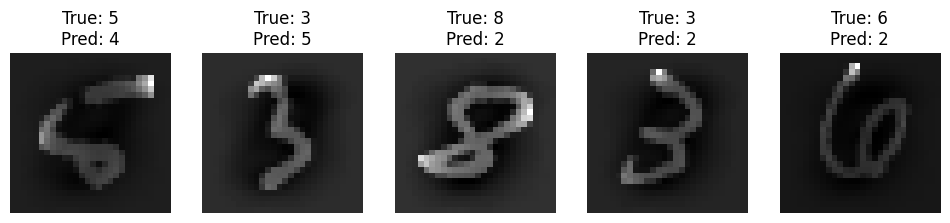

In [352]:
num_to_plot = min(5, len(incorrect_indices))
plt.figure(figsize=(12, 3))

for i in range(num_to_plot):
    idx = incorrect_indices[i].item()
    img = testing_inputs[idx].reshape(28, 28)
    true_label = testing_targets[idx].item()
    pred_label = predicted_classes[idx].item()

    plt.subplot(1, num_to_plot, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.show()